Sample routine for processing of DOE ARM KAZR2 data

In [1]:
import datetime
import numpy as np
import xarray as xr
import numba
import matplotlib.pyplot as plt

import pyPamtraRadarMoments

%matplotlib inline

load data. The file has been truncated to the first 100 time steps. See http://www.arm.gov/data for complete file

In [2]:
fIn = 'data/olikazrspeccmaskgecopolM1.a0.20160926.180000.part.nc'
specData = xr.open_dataset(fIn)

get settings from netCDf file

In [3]:
verbosity = 1

no_ave = int(specData.attrs[u'num_spectral_averages'])
max_v = float(specData.attrs[u'nyquist_velocity'].split(' ')[0])
min_v = -float(specData.attrs[u'nyquist_velocity'].split(' ')[0])

noT, noH = specData.locator_mask.shape
nFFT = specData.speclength.shape[0]

calibrationOffset = 0
calibConstant = float(specData.attrs[u'cal_constant'].split(' ')[0])

other settings

In [4]:
nPeaks = 2
minHeight =300
hildeDiscardedLowestValues = 0.005 #percentage of spectral bins discarded for hildebrand application.
missingNumber = -9999
fType = np.float32
iType = np.int32


Prepare Output

In [5]:
peaks  = range(nPeaks)
outData = dict()
outData['reflectivityFromSpectra'] = xr.DataArray(
      missingNumber*np.ones((noT,noH),dtype=fType),
      coords=[specData.time.values,specData.range.values],
      dims=('time','range'),
      attrs={'units':'dBz'},
      encoding={'_FillValue':missingNumber}
      )
outData['reflectivity'] = xr.DataArray(
      missingNumber*np.ones((noT,noH,nPeaks),dtype=fType),
      coords=[specData.time.values,specData.range.values,peaks],
      dims=('time','range','peak'),
      attrs={'units':'dBz'},
      encoding={'_FillValue':missingNumber}
      )
outData['mean_doppler_velocity'] = xr.DataArray(
      missingNumber*np.ones((noT,noH,nPeaks),dtype=fType),
      coords=[specData.time.values,specData.range.values,peaks],
      dims=('time','range','peak'),
      attrs={'units':'m/s'},
      encoding={'_FillValue':missingNumber}
      )
outData['doppler_spectrum_width'] = xr.DataArray(
      missingNumber*np.ones((noT,noH,nPeaks),dtype=fType),
      coords=[specData.time.values,specData.range.values,peaks],
      dims=('time','range','peak'),
      attrs={'units':'m/s'},
      encoding={'_FillValue':missingNumber}
      )
outData['skewness'] = xr.DataArray(
      missingNumber*np.ones((noT,noH,nPeaks),dtype=fType),
      coords=[specData.time.values,specData.range.values,peaks],
      dims=('time','range','peak'),
      attrs={'units':'-'},
      encoding={'_FillValue':missingNumber}
      )
outData['kurtosis'] = xr.DataArray(
      missingNumber*np.ones((noT,noH,nPeaks),dtype=fType),
      coords=[specData.time.values,specData.range.values,peaks],
      dims=('time','range','peak'),
      attrs={'units':'-'},
      encoding={'_FillValue':missingNumber}
      )
outData['left_slope'] = xr.DataArray(
      missingNumber*np.ones((noT,noH,nPeaks),dtype=fType),
      coords=[specData.time.values,specData.range.values,peaks],
      dims=('time','range','peak'),
      attrs={'units':'dB s/m'},
      encoding={'_FillValue':missingNumber}
      )
outData['right_slope'] = xr.DataArray(
      missingNumber*np.ones((noT,noH,nPeaks),dtype=fType),
      coords=[specData.time.values,specData.range.values,peaks],
      dims=('time','range','peak'),
      attrs={'units':'dB s/m'},
      encoding={'_FillValue':missingNumber}
      )
outData['left_edge'] = xr.DataArray(
      missingNumber*np.ones((noT,noH,nPeaks),dtype=fType),
      coords=[specData.time.values,specData.range.values,peaks],
      dims=('time','range','peak'),
      attrs={'units':'m/s'},
      encoding={'_FillValue':missingNumber}
      )
outData['right_edge'] = xr.DataArray(
      missingNumber*np.ones((noT,noH,nPeaks),dtype=fType),
      coords=[specData.time.values,specData.range.values,peaks],
      dims=('time','range','peak'),
      attrs={'units':'m/s'},
      encoding={'_FillValue':missingNumber}
      )
outData['snr'] = xr.DataArray(
      missingNumber*np.ones((noT,noH,nPeaks),dtype=fType),
      coords=[specData.time.values,specData.range.values,peaks],
      dims=('time','range','peak'),
      attrs={'units':'dB'},
      encoding={'_FillValue':missingNumber}
      )
outData['noise'] = xr.DataArray(
      missingNumber*np.ones((noT,noH),dtype=fType),
      coords=[specData.time.values,specData.range.values],
      dims=('time','range'),
      attrs={'units':'dBz'},
      encoding={'_FillValue':missingNumber}
      )
outData['noise1km_mean'] = xr.DataArray(
      missingNumber*np.ones((noT),dtype=fType),
      coords=[specData.time.values],
      dims=('time'),
      attrs={'units':'dBz'},
      encoding={'_FillValue':missingNumber}
      )
outData['noise1km_max'] = xr.DataArray(
      missingNumber*np.ones((noT),dtype=fType),
      coords=[specData.time.values],
      dims=('time'),
      attrs={'units':'dBz'},
      encoding={'_FillValue':missingNumber}
      )
outData['quality'] = xr.DataArray(
      int(missingNumber)*np.ones((noT,noH),dtype=int),
      coords=[specData.time.values,specData.range.values],
      dims=('time','range'),
      attrs={'units':'bytes',
             'desciption':"1st byte: aliasing; 2nd byte: more peaks present; 7th: no peak found; 8th: principal peak isolated"},
      encoding={'_FillValue':int(missingNumber)}
      )
outData = xr.Dataset(outData)

For calibration we need the range for every pixel with data

In [6]:
@numba.jit(nopython=True) #turn on the boosters!
def createHeight1D(noS,noT,noH,locator_mask,ranges):
    heights1D = np.zeros(noS)
    for tt in range(noT):
      for hh in range(noH):
        specIndex = locator_mask[tt,hh]
        if not np.isnan(locator_mask[tt,hh]):
          heights1D[int(specIndex)] = ranges[hh]
    return heights1D

heights1DT = createHeight1D(specData.spectra.shape[0],noT,noH,specData.locator_mask.values,specData.range.values).T
heights1DTSquared = heights1DT**2



Calibrating

In [7]:
spectraCalib1D = (10**(0.1*specData.spectra.values.T) * heights1DT**2 * 10**(.1*calibConstant)  * 10**(.1*calibrationOffset)).T
spectraSemiCalib1D = (10**(0.1*specData.spectra.values.T) * 10**(.1*calibConstant)  * 10**(.1*calibrationOffset)).T


The loop over all data

In [8]:
locatorMask = np.array(specData.locator_mask.values)


In [ ]:
for tt in xrange(noT):

      #estimate noise
    specIndicesThisTime = np.ma.masked_invalid(specData.locator_mask.values[tt][specData.range.values > minHeight]).compressed().astype(int)
    if len(specIndicesThisTime) < 1: continue

    #remove 5 lowest values to get rid of strange dips in the spectrum
    spec4Hilde = np.sort(spectraSemiCalib1D[specIndicesThisTime].ravel())
    cutOffValue = int(np.floor(len(spec4Hilde)*hildeDiscardedLowestValues))
    meanNoiseColumn, maxNoiseColumn = pyPamtraRadarMoments.calc_hildebrandSekhon(spec4Hilde[cutOffValue:], no_ave = no_ave,verbose=verbosity)

                               
    outData['noise1km_max'][tt] = maxNoiseColumn
    outData['noise1km_mean'][tt] = meanNoiseColumn

    for hh in xrange(noH):
        print tt+1, "of", noT,  hh, "of", noH

        #find Data
        specIndex = locatorMask[tt,hh]

        #skip noise
        if np.isnan(specIndex): continue
        else: specIndex = int(specIndex)

        #remove data below minHeight
        if heights1DT[specIndex] < minHeight:
            continue

        #pick calibrated spectrum
        spectraCalib = spectraCalib1D[specIndex]

        #estimate noise
        noise_mean = meanNoiseColumn * heights1DTSquared[specIndex]
        noise_max = maxNoiseColumn * heights1DTSquared[specIndex]


        #poor man's fixed echo filter!
        if np.mean(spectraCalib[nFFT/2-1:nFFT/2+2]) > 2* np.mean(spectraCalib[[nFFT/2-2,nFFT/2+2]]):
            spectraCalib[nFFT/2-1:nFFT/2+2] = np.interp([1,2,3],[0,4],spectraCalib[[nFFT/2-2,nFFT/2+2]])

            
        kwargs = {
            'verbose'  :  verbosity, 
            'max_v'  :  max_v, 
            'min_v'  :  min_v, 
            'no_ave'  :  no_ave, 
            'npeaks'  :  nPeaks, 
            'noise_distance_factor'  :  0, 
            'noise_mean'  :  noise_mean,
            'noise_max'  :  noise_max,
            'peak_min_snr' : 1.2, 
            'peak_min_bins' : 2, 
            'smooth_spectrum' :  True,
            'use_wider_peak' : False,
        }
            
            
        #now estimate the moments
        (
        res_spectrum_out,
        res_moments,
        res_slope,
        res_edge,
        outData['quality'].values[tt,hh],
        outData['noise'].values[tt,hh], #array(0.00013121511437930167, dtype=float32)
        ) =  pyPamtraRadarMoments.calc_radarMoments(spectraCalib,**kwargs)

        
        #map data to prepared arrays  
        outData['reflectivityFromSpectra'].values[tt,hh] = 10*np.log10(np.sum(spectraCalib))
        outData['reflectivity'].values[tt,hh] = res_moments[0]
        outData['mean_doppler_velocity'].values[tt,hh] = res_moments[1]
        outData['doppler_spectrum_width'].values[tt,hh] = res_moments[2]
        outData['skewness'].values[tt,hh] = res_moments[3]
        outData['kurtosis'].values[tt,hh] = res_moments[4]
        outData['left_slope'].values[tt,hh] = res_slope[0]
        outData['right_slope'].values[tt,hh] = res_slope[1]
        outData['left_edge'].values[tt,hh] = res_edge[0]
        outData['right_edge'].values[tt,hh] = res_edge[1]

        #simple aliasing detection
        if (res_spectrum_out[0] > 0) & (res_spectrum_out[1] > 0):
            outData['quality'].values[tt,hh] += 1



take care of SNR and log units



In [12]:
outData['snr'].values = 10*np.log10(outData['reflectivity'].values.T/(outData['noise'].values.T * specData.spectra.shape[1])).T
outData['snr'].values[outData['reflectivity'].values == missingNumber] = missingNumber
outData['reflectivity'].values = 10*np.log10(outData['reflectivity'].values)
outData['noise'].values = 10*np.log10(outData['noise'].values * specData.spectra.shape[1])
outData['noise1km_mean'].values = 10*np.log10(outData['noise1km_mean'].values * specData.spectra.shape[1] * 1000**2)
outData['noise1km_max'].values = 10*np.log10(outData['noise1km_max'].values * specData.spectra.shape[1] * 1000**2)


/Users/mmaahn/anaconda/envs/numpy1.13/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/Users/mmaahn/anaconda/envs/numpy1.13/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()
/Users/mmaahn/anaconda/envs/numpy1.13/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log10


add meta data

In [13]:
outData.time.encoding['units'] = u'seconds since 1970-01-01 00:00:00'
outData.attrs['author'] = "Maximilian Maahn"
outData.attrs['created'] = str(datetime.datetime.now())
outData.attrs['version'] = "pyPamtraRadarMoments Version "+ str(pyPamtraRadarMoments.__version__)
#copy attrinbutes

keys =   [
    u'site_id',
    u'facility_id',
    u'platform_id',
    u'location_description',
    u'antenna_altitude',
    u'antenna_diameter',
    u'attenuation',
    u'cal_constant',
    u'fft_len',
    u'num_spectral_averages',
    u'nyquist_velocity',
    u'pulse_repetition_frequency',
    u'pulse_width',
    u'radar_operating_frequency',
    u'rx_noise',
    u'zero_gate_range',
  ]


for key in keys:
    outData.attrs[key] = specData.attrs[key]

Plot reflectivity

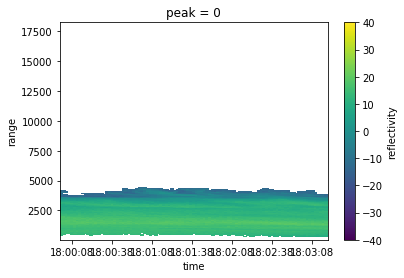

In [14]:
outData['reflectivity'][:,:,0].T.plot(vmin=-40,vmax=40)

Store data

In [ ]:
#enable compression
for k in outData.keys():
    outData[k].encoding['zlib'] = True

outData.to_netcdf(fOut)

Compare with reference file with moments provided by teh ARM program. Small differences are possible for low SNR, due to different treatment of multiple peaks and due to ground clutter.

In [19]:
refFile = xr.open_dataset('data/olikazrgeM1.a1.20160926.000000.part.nc')

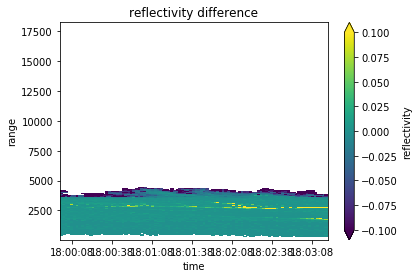

In [20]:
( outData['reflectivity'][:,:,0] - refFile.reflectivity).T.plot(vmin=-0.1,vmax=0.1)
plt.title('reflectivity difference')



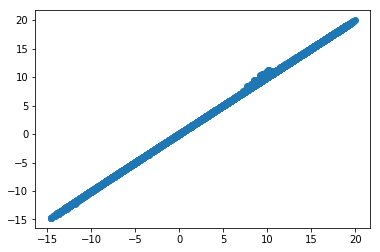

In [21]:
plt.scatter(refFile.reflectivity.values, outData['reflectivity'][:,:,0].values)